In [27]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import geoengine as ge

In [28]:
import geoengine as ge

In [29]:
ge.initialize("https://respect.app.geoengine.io/api", token="0ef608e2-70de-4395-8bf1-79c7cad4360e")

In [30]:
session = ge.get_session()
session

Server:              https://respect.app.geoengine.io/api
Session Id:          0ef608e2-70de-4395-8bf1-79c7cad4360e
Session valid until: 2023-02-02T23:00:14.899Z

Use the pre-defined workflow

In [33]:
ndvi_workflow = ge.workflow_by_id("27081943-46a8-5ff5-9248-7fe83d5cb54c")

In [34]:
ndvi_workflow.get_result_descriptor()

Data type:         F32
Spatial Reference: EPSG:32717
Measurement:       unitless

Request data from  the virtual layer

In [35]:
time_start = datetime.strptime(
    '2019-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime(
    '2019-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

query_rectangle = ge.QueryRectangle(
        #ge.BoundingBox2D(712000.0,956000.0, 714000.0,959000.0), # ~ecuador
        ge.BoundingBox2D(712000, 9559000, 715000, 9562000), # ~ecuador
        ge.TimeInterval(time_start, time_end),
        srs= "EPSG:32717",
        resolution=ge.SpatialResolution(10,10)
        )

query_rectangle

QueryRectangle( 
    BoundingBox2D(xmin=712000, ymin=9559000, xmax=715000, ymax=9562000)
    TimeInterval(start=2019-04-01 12:00:00+00:00, end=2019-04-01 12:00:00+00:00)
    SpatialResolution(x=10, y=10)
    srs=EPSG:32717 
)

In [36]:
ndvi_array = ndvi_workflow.get_xarray(query_rectangle)
display(ndvi_array)

<xarray.DataArray (band: 1, y: 300, x: 300)>
array([[[ 0.        ,  0.        ,  0.        , ..., -0.6211699 ,
         -0.674674  , -0.7323853 ],
        [ 0.        ,  0.        ,  0.        , ..., -0.67750496,
         -0.7050505 , -0.72124493],
        [ 0.        ,  0.        ,  0.        , ..., -0.7234966 ,
         -0.7119785 , -0.71946967],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.70711756,
         -0.6784106 , -0.64243406],
        [ 0.        ,  0.        ,  0.        , ..., -0.62167966,
         -0.5882192 , -0.542826  ],
        [ 0.        ,  0.        ,  0.        , ..., -0.6207185 ,
         -0.5671388 , -0.5062571 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.12e+05 7.12e+05 7.12e+05 ... 7.15e+05 7.15e+05
  * y            (y) float64 9.562e+06 9.562e+06 ... 9.559e+06 9.559e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    crs:           EPSG:32717
    res:           (10.0, -10.0)
    transform:     | 10.00, 0.00, 712000.00|\n| 0.00,-10.00, 9562000.00|\n| 0...

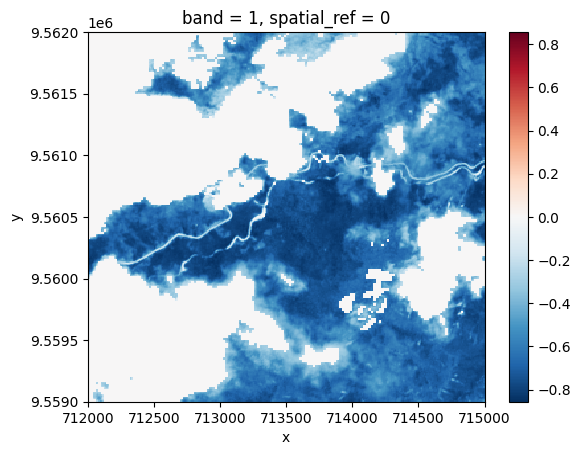

In [37]:
ndvi_array.plot()

Extend the workflow

In [38]:
workflow_spec = {
	"type": "Raster",
	"operator": {
				"type": "Expression",
				"params": {
					"expression": "(-1.0* A)", # this is the NDVI formula
					"outputType": "F32",
                    "mapNoData": False
				},
                "sources": {
                    "a": ndvi_workflow.workflow_definition()["operator"]										
				}
			}
}
inverse_workflow = ge.register_workflow(workflow_spec)
inverse_workflow

{'id': 'fff55697-ce86-5583-958c-480c22f6e184'}


fff55697-ce86-5583-958c-480c22f6e184

Request inverse data

In [39]:
inverse_array = inverse_workflow.get_xarray(query_rectangle)

Query the NDVI raster

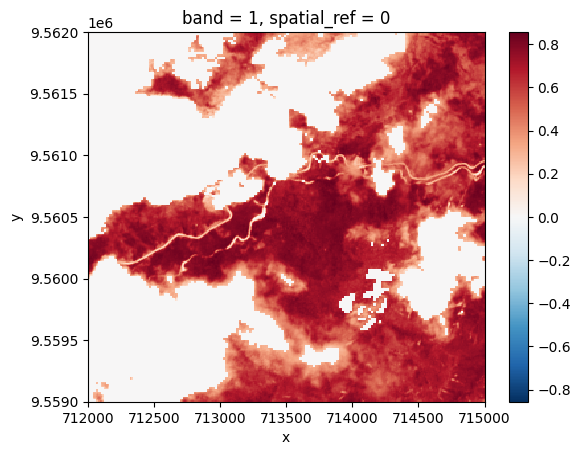

In [40]:
inverse_array.plot()

## Switch to UI

## Upload points + combine with NDVI

In [41]:
import pandas as pd
import geopandas

fieldpoints_gdf = geopandas.read_file("workshop_points_2.gpkg", layer='workshop_points_2')
fieldpoints_gdf




,geometry
0,MULTIPOINT (-79.08366 -3.96671)
1,MULTIPOINT (-79.06372 -3.96666)
2,MULTIPOINT (-79.07524 -3.97365)
3,MULTIPOINT (-79.07633 -3.97251)
4,MULTIPOINT (-79.07882 -3.97138)
...,...
96,MULTIPOINT (-79.07243 -3.94600)
97,MULTIPOINT (-79.07093 -3.94856)
98,MULTIPOINT (-79.07976 -3.95113)
99,MULTIPOINT (-79.06713 -3.98709)


In [42]:
points_id = ge.upload_dataframe(fieldpoints_gdf)

points_id

0bb91186-6c85-4c4b-93b7-bb51884814ed

In [43]:
def raster_vector_join_workflow(raster_workflow, vector_workflow):
	return {
		"type": "Vector",
		"operator": {
			"type": "RasterVectorJoin",
			"params": {
				"names": ["NDVI"],
				"temporalAggregation": "none",
				"featureAggregation": "mean"
			},
			"sources": {
				"vector": vector_workflow["operator"],
				"rasters": [ raster_workflow["operator"] ] # reuse the root operator of the raster workflow
			}
		}
}

def vector_source_workflow(dataset_id):
    return {
        "type": "Vector",
        "operator": {
            "type": "OgrSource",
            "params": {
                "data": {
                    "type": "internal",
                    "datasetId": str(dataset_id)
                },
            },
        },
    }

def reproject_workflow(workflow, srs):
	return {
		"type": "Vector",
		"operator": {
			"type": "Reprojection",
			"params": {
				"targetSpatialReference": "EPSG:32717"
			},
			"sources": {
				"source": workflow["operator"],
			},
		},
	}



In [44]:
raster_workflow_spec = inverse_workflow.workflow_definition()
raster_workflow_spec


{'type': 'Raster',
 'operator': {'type': 'Expression',
  'params': {'expression': '(-1.0* A)',
   'outputType': 'F32',
   'outputMeasurement': None,
   'mapNoData': False},
  'sources': {'a': {'type': 'Expression',
    'params': {'expression': '    (A-B)/(A+B)  ',
     'outputType': 'F32',
     'outputMeasurement': None,
     'mapNoData': False},
    'sources': {'a': {'type': 'GdalSource',
      'params': {'data': {'type': 'internal',
        'datasetId': '7b1fb612-bf22-44dc-beb7-079dfdc427bc'}}},
     'b': {'type': 'GdalSource',
      'params': {'data': {'type': 'internal',
        'datasetId': 'b06d9125-bf97-46ed-b8a9-86c32e7d8008'}}},
     'c': None,
     'd': None,
     'e': None,
     'f': None,
     'g': None,
     'h': None}},
   'b': None,
   'c': None,
   'd': None,
   'e': None,
   'f': None,
   'g': None,
   'h': None}}}

In [45]:
vector_workflow_spec = vector_source_workflow(str(points_id))
vector_workflow_spec

{'type': 'Vector',
 'operator': {'type': 'OgrSource',
  'params': {'data': {'type': 'internal',
    'datasetId': '0bb91186-6c85-4c4b-93b7-bb51884814ed'}}}}

In [46]:
reproject_workflow_spec = reproject_workflow(vector_workflow_spec, "EPSG:32717")
reproject_workflow_spec

{'type': 'Vector',
 'operator': {'type': 'Reprojection',
  'params': {'targetSpatialReference': 'EPSG:32717'},
  'sources': {'source': {'type': 'OgrSource',
    'params': {'data': {'type': 'internal',
      'datasetId': '0bb91186-6c85-4c4b-93b7-bb51884814ed'}}}}}}

In [47]:

joined_workflow_spec = raster_vector_join_workflow(raster_workflow_spec, reproject_workflow_spec)
joined_workflow_spec



{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['NDVI'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'Reprojection',
    'params': {'targetSpatialReference': 'EPSG:32717'},
    'sources': {'source': {'type': 'OgrSource',
      'params': {'data': {'type': 'internal',
        'datasetId': '0bb91186-6c85-4c4b-93b7-bb51884814ed'}}}}},
   'rasters': [{'type': 'Expression',
     'params': {'expression': '(-1.0* A)',
      'outputType': 'F32',
      'outputMeasurement': None,
      'mapNoData': False},
     'sources': {'a': {'type': 'Expression',
       'params': {'expression': '    (A-B)/(A+B)  ',
        'outputType': 'F32',
        'outputMeasurement': None,
        'mapNoData': False},
       'sources': {'a': {'type': 'GdalSource',
         'params': {'data': {'type': 'internal',
           'datasetId': '7b1fb612-bf22-44dc-beb7-079dfdc427bc'}}},
        'b': {'type': 'GdalSource',
         'params

In [48]:
upload_points_with_ndvi_id = ge.register_workflow(joined_workflow_spec)
upload_points_with_ndvi_id

{'id': '8d8cfa97-9935-57f4-aeac-8f6e69003f0b'}


8d8cfa97-9935-57f4-aeac-8f6e69003f0b

In [49]:
upload_points_with_ndvi_id.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:32717
Columns:
  NDVI:
    Column Type: float
    Measurement: unitless

In [50]:
point_gdf = upload_points_with_ndvi_id.get_dataframe(query_rectangle)
point_gdf

,geometry,NDVI,start,end
0,POINT (712772.999 9561306.368),NaN,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
1,POINT (714988.083 9561306.368),0.812872,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
2,POINT (713705.983 9560535.904),0.763673,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
3,POINT (713585.598 9560662.308),0.713770,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
4,POINT (713308.712 9560788.713),NaN,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
5,POINT (713705.983 9560457.654),0.779495,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
6,POINT (715000.122 9559988.152),0.396624,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
7,POINT (712688.729 9559446.420),NaN,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
8,POINT (712658.633 9560006.210),0.440902,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00
9,POINT (712779.018 9560265.038),0.762751,2019-03-21 00:00:00+00:00,2019-04-04 00:00:00+00:00


<AxesSubplot: >

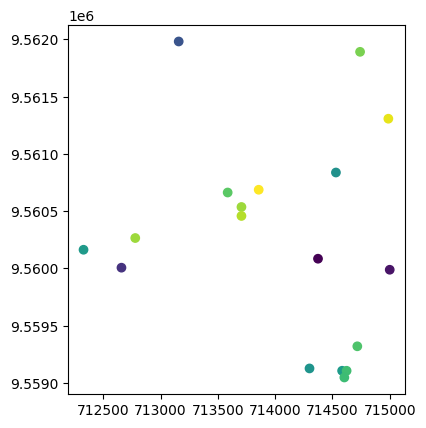

In [51]:
point_gdf.plot("NDVI")